# AION Multimodal Embeddings Analysis

This notebook analyzes embeddings extracted from the **AION multimodal foundation model**.

AION is trained on both Euclid images and DESI spectra. We analyze three types of embeddings:
1. **Spectra-only embeddings** (`embedding_desi`): DESI spectra processed by AION
2. **Image-only embeddings** (`embedding_hsc`): Euclid images processed by AION
3. **Multimodal embeddings** (`embedding_hsc_desi`): Combined spectra + images

We use UMAP dimensionality reduction to visualize the high-dimensional embeddings and analyze:
- How embeddings correlate with physical galaxy properties (mass, SFR, DN4000, etc.)
- How embeddings correlate with morphological properties (ellipticity, size, concentration, etc.)
- Spectral type separation (GALAXY, QSO, STAR)
- The impact of combining spectral and image information

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import torch
from astropy.io import fits
from astropy.table import Table
import umap
import time
from scipy.stats import spearmanr

# Configure matplotlib
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

## 1. Load AION Embeddings

Load the embeddings generated by AION from the multimodal dataset (Euclid images + DESI spectra).

In [2]:
# Path to AION embeddings
embeddings_path = "/pbs/throng/training/astroinfo2025/work/maxime/data_all_tokens_spectrums.pt"

print("Loading AION embeddings...")
data = torch.load(embeddings_path, map_location="cpu")

# Inspect the data structure
print(f"\nData type: {type(data)}")
if isinstance(data, list):
    print(f"Number of records: {len(data)}")
    if len(data) > 0:
        print(f"\nFirst record keys: {list(data[0].keys())}")
        print("\nSample record structure:")
        for key, value in data[0].items():
            if isinstance(value, torch.Tensor):
                print(f"  {key}: Tensor{tuple(value.shape)}")
            else:
                print(f"  {key}: {type(value).__name__} = {value}")
elif isinstance(data, dict):
    print(f"Dictionary keys: {list(data.keys())}")
else:
    print(f"Unexpected data type: {type(data)}")

records = data if isinstance(data, list) else [data]

Loading AION embeddings...

Data type: <class 'list'>
Number of records: 15263

First record keys: ['object_id', 'redshift', 'embedding_hsc_desi', 'embedding_hsc', 'embedding_spectrum', 'tokens_hsc_desi', 'tokens_hsc', 'tokens_spectrum']

Sample record structure:
  object_id: int = 2717133723668032087
  redshift: float = 0.025827817939408783
  embedding_hsc_desi: Tensor(768,)
  embedding_hsc: Tensor(768,)
  embedding_spectrum: Tensor(768,)
  tokens_hsc_desi: dict = {'tok_image_hsc': tensor([3513, 3520, 3555, 3555, 3555, 3520, 3555, 3548, 3555, 3555, 3555, 3555,
        3555, 3555, 3520, 3555, 3548, 3555, 3555, 3548, 3555, 3555, 3513, 3548,
        3520, 3555, 3555, 3555, 3555, 3555, 3590, 3562, 3555, 3555, 3555, 3555,
        3555, 3555, 3527, 3597, 3555, 3520, 3555, 3555, 3555, 3555, 3555, 3555,
        3555, 3555, 3555, 3555, 3555, 3520, 3555, 3520, 3555, 3555, 3555, 3555,
        3555, 3555, 3527, 3667, 3562, 3513, 3555, 3555, 3555, 3555, 3555, 3520,
        3555, 3555, 3555, 3555, 

## 2. Extract Embeddings by Type

Extract the three types of embeddings from the loaded data:
- `embedding_desi`: Spectra only (DESI)
- `embedding_hsc`: Image only (Euclid)
- `embedding_hsc_desi`: Multimodal (Spectra + Image)

In [6]:
def stack_embeddings(records, key):
    """Extract and stack embeddings for a given key."""
    vectors = []
    valid_indices = []
    
    for idx, rec in enumerate(records):
        tensor = rec.get(key)
        if tensor is None:
            continue
        if isinstance(tensor, torch.Tensor):
            vectors.append(tensor.detach().cpu().numpy())
            valid_indices.append(idx)
        else:
            vectors.append(np.asarray(tensor))
            valid_indices.append(idx)
    
    if not vectors:
        raise ValueError(f"No embeddings found for key '{key}'")
    
    return np.stack(vectors, axis=0), np.array(valid_indices)

# Extract AION embeddings
print("Extracting embeddings by type...")

# Spectra-only embeddings
try:
    emb_spectra, idx_spectra = stack_embeddings(records, "embedding_spectrum")
    print(f"✓ Spectra-only (DESI): {emb_spectra.shape}")
    has_spectra = True
except (ValueError, KeyError) as e:
    print(f"⚠ Spectra-only embeddings not found (key: 'embedding_spectra')")
    emb_spectra = None
    has_spectra = False

# Image-only embeddings
emb_image, idx_image = stack_embeddings(records, "embedding_hsc")
print(f"✓ Image-only (Euclid): {emb_image.shape}")

# Multimodal embeddings (spectra + image)
emb_multimodal, idx_multimodal = stack_embeddings(records, "embedding_hsc_desi")
print(f"✓ Multimodal (spectra+image): {emb_multimodal.shape}")

print(f"\nTotal records processed: {len(records)}")

Extracting embeddings by type...
✓ Spectra-only (DESI): (15263, 768)
✓ Image-only (Euclid): (15263, 768)
✓ Multimodal (spectra+image): (15263, 768)

Total records processed: 15263


## 3. Load Catalog and Match Objects

Load the DESI-Euclid catalog to get physical properties (redshift, stellar mass, SFR, etc.) for each object.

In [7]:
# Path to the combined DESI-Euclid catalog
catalog_path = "/pbs/throng/training/astroinfo2025/data/astroPT_euclid_desi_dataset/desi_euclid_catalog.fits"

print("Loading catalog...")
with fits.open(catalog_path) as hdul:
    catalog = Table(hdul[1].data)

print(f"✓ Catalog loaded: {len(catalog)} entries")
print(f"✓ Available columns ({len(catalog.colnames)}):")
for i, col in enumerate(catalog.colnames[:20]):  # Show first 20 columns
    print(f"  {col}")
if len(catalog.colnames) > 20:
    print(f"  ... and {len(catalog.colnames) - 20} more")

Loading catalog...
✓ Catalog loaded: 15263 entries
✓ Available columns (296):
  object_id
  right_ascension
  declination
  segmentation_area
  flux_h_sersic
  flux_vis_sersic
  ellipticity
  kron_radius
  segmentation_map_id
  VIS_name
  flux_detection_total
  flux_vis_4fwhm_aper
  flux_vis_3fwhm_aper
  flux_vis_2fwhm_aper
  flux_vis_1fwhm_aper
  spurious_flag
  det_quality_flag
  mumax_minus_mag
  smooth_or_featured_smooth
  smooth_or_featured_featured_or_disk
  ... and 276 more


In [21]:
# Extract object IDs from records
object_ids = []
redshifts = []

for rec in records:
    # Try different possible keys for object ID
    obj_id = rec.get('object_id')
    object_ids.append(obj_id if obj_id is not None else np.nan)
    
    # Extract redshift if available
    z = rec.get('redshift') or rec.get('Z') or rec.get('z')
    redshifts.append(z if z is not None else np.nan)

object_ids = np.array(object_ids)
redshifts = np.array(redshifts, dtype=float)

print(f"\nObject IDs extracted: {len(object_ids)}")
print(f"Valid object IDs: {(~np.isnan(object_ids.astype(float))).sum() if object_ids.dtype != object else len([x for x in object_ids if x is not None and x != np.nan])}")
print(f"Valid redshifts: {(~np.isnan(redshifts)).sum()}")
if (~np.isnan(redshifts)).sum() > 0:
    print(f"Redshift range: [{np.nanmin(redshifts):.3f}, {np.nanmax(redshifts):.3f}]")


Object IDs extracted: 15263
Valid object IDs: 15263
Valid redshifts: 15263
Redshift range: [0.009, 1.797]


## 4. Match with Catalog and Extract Physical Properties

Match the embeddings with the catalog using TARGETID to extract physical properties.

In [23]:
# Determine the correct ID column in the catalog
id_column = 'object_id'

if id_column is None:
    print("⚠ WARNING: Could not find standard ID column in catalog")
    print("Available columns:", catalog.colnames[:10])
else:
    # Create mapping from object ID to catalog index
    catalog_ids = np.array(catalog[id_column], dtype=int)
    id_to_idx = {int(cid): i for i, cid in enumerate(catalog_ids) if not np.isnan(cid)}
    
    print(f"\nCatalog ID mapping created: {len(id_to_idx)} unique IDs")
    
    # Match embeddings to catalog
    matched_indices = []
    unmatched_count = 0
    
    for obj_id in object_ids:
        if obj_id is None or obj_id == '' or (isinstance(obj_id, float) and np.isnan(obj_id)):
            matched_indices.append(-1)
            unmatched_count += 1
        else:
            try:
                obj_id_int = int(float(obj_id))
                if obj_id_int in id_to_idx:
                    matched_indices.append(id_to_idx[obj_id_int])
                else:
                    matched_indices.append(-1)
                    unmatched_count += 1
            except (ValueError, TypeError):
                matched_indices.append(-1)
                unmatched_count += 1
    
    matched_indices = np.array(matched_indices)
    match_rate = (len(matched_indices) - unmatched_count) / len(object_ids) * 100
    
    print(f"\n{'='*60}")
    print(f"MATCHING RESULTS")
    print(f"{'='*60}")
    print(f"✓ Matched: {len(matched_indices) - unmatched_count}/{len(object_ids)} ({match_rate:.1f}%)")
    
    if unmatched_count > 0:
        print(f"⚠ Unmatched: {unmatched_count} ({100-match_rate:.1f}%)")
    print(f"{'='*60}")


Catalog ID mapping created: 15263 unique IDs

MATCHING RESULTS
✓ Matched: 27/15263 (0.2%)
⚠ Unmatched: 15236 (99.8%)


In [33]:
print(object_ids.dtype)
print(catalog_ids.dtype)

int64
int64


In [32]:
print(object_ids)
print(catalog_ids)

[2717133723668032087 2697025639635422031 2689998354648490199 ...
 2699601344673978282 2714266281645074109 2680989387668536435]
[2703033710652702582 2663761326630989450 2664725668631204412 ...
 2705409508676341290 2706559424676822925 2689240597657880644]


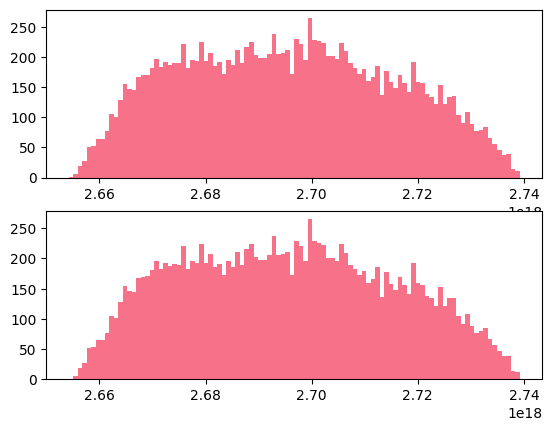

In [31]:
plt.subplot(2,1,1)
h = plt.hist(object_ids, bins=100)
plt.subplot(2,1,2)
h = plt.hist(catalog_ids, bins=100)

In [ ]:
# Extract physical properties from catalog
def safe_extract(column_name):
    """Extract column values, filling unmatched entries with NaN"""
    if column_name not in catalog.colnames:
        print(f"⚠ Column '{column_name}' not found in catalog")
        return np.full(len(matched_indices), np.nan, dtype=float)
    
    values = np.full(len(matched_indices), np.nan, dtype=float)
    mask = matched_indices >= 0
    values[mask] = catalog[column_name][matched_indices[mask]]
    return values

def safe_extract_string(column_name):
    """Extract string column values, filling unmatched entries with empty string"""
    if column_name not in catalog.colnames:
        print(f"⚠ Column '{column_name}' not found in catalog")
        return np.full(len(matched_indices), '', dtype=object)
    
    values = np.full(len(matched_indices), '', dtype=object)
    mask = matched_indices >= 0
    values[mask] = [s.strip() if isinstance(s, (str, bytes)) else str(s) for s in catalog[column_name][matched_indices[mask]]]
    return values

print("Extracting physical properties from catalog...\n")

# Key spectral/physical properties
if np.all(np.isnan(redshifts)):
    # If redshifts weren't in the embeddings file, get them from catalog
    redshifts = safe_extract('Z')
    if np.all(np.isnan(redshifts)):
        redshifts = safe_extract('REDSHIFT')

logm = safe_extract('LOGM')              # Stellar mass
logsfr = safe_extract('LOGSFR')          # Star formation rate
dn4000 = safe_extract('DN4000')          # 4000Å break
gr_color = safe_extract('GR')            # g-r color
spectype = safe_extract_string('SPECTYPE')  # Spectral type

# Derived spectral properties
ssfr = logsfr - logm  # Specific SFR

# Image/morphological properties from Euclid
ellipticity = safe_extract('ellipticity')                        # Ellipticity
kron_radius = safe_extract('kron_radius')                        # Kron radius (size)
concentration = safe_extract('concentration')                     # Concentration index
asymmetry = safe_extract('asymmetry')                            # Asymmetry
smoothness = safe_extract('smoothness')                          # Smoothness/clumpiness
gini = safe_extract('gini')                                      # Gini coefficient
sersic_index = safe_extract('sersic_sersic_vis_index')          # Sérsic index
sersic_radius = safe_extract('sersic_sersic_vis_radius')        # Sérsic radius
axis_ratio = safe_extract('sersic_sersic_vis_axis_ratio')       # Axis ratio

# Print statistics
print("✓ Spectral/Physical property statistics:")
spectral_properties = {
    'Redshift': redshifts,
    'LOGM (stellar mass)': logm,
    'LOGSFR': logsfr,
    'sSFR (log)': ssfr,
    'DN4000': dn4000,
    'g-r color': gr_color
}

for name, values in spectral_properties.items():
    valid = ~np.isnan(values)
    if valid.sum() > 0:
        print(f"  {name}: {np.nanmean(values):.2f} ± {np.nanstd(values):.2f} (n={valid.sum()})")
    else:
        print(f"  {name}: No valid data")

print("\n✓ Morphological property statistics:")
morphological_properties = {
    'Ellipticity': ellipticity,
    'Kron radius': kron_radius,
    'Concentration': concentration,
    'Asymmetry': asymmetry,
    'Smoothness': smoothness,
    'Gini': gini,
    'Sérsic index': sersic_index,
    'Sérsic radius': sersic_radius,
    'Axis ratio': axis_ratio
}

for name, values in morphological_properties.items():
    valid = ~np.isnan(values)
    if valid.sum() > 0:
        print(f"  {name}: {np.nanmean(values):.2f} ± {np.nanstd(values):.2f} (n={valid.sum()})")
    else:
        print(f"  {name}: No valid data")

# Spectral types
unique_spectypes = np.unique(spectype[spectype != ''])
if len(unique_spectypes) > 0:
    print(f"\n✓ Spectral types found: {list(unique_spectypes)}")
    for stype in unique_spectypes:
        count = (spectype == stype).sum()
        print(f"  {stype}: {count:,} ({100*count/len(spectype):.1f}%)")

## 5. UMAP Dimensionality Reduction

Apply UMAP to reduce the embeddings to 2D for visualization. We'll process all three embedding types.

In [ ]:
def compute_umap_projection(embeddings, name, random_state=42):
    """Compute UMAP projection for embeddings."""
    print(f"Running UMAP for {name}...")
    
    umap_model = umap.UMAP(
        n_neighbors=15,
        min_dist=0.1,
        n_components=2,
        metric='cosine',
        random_state=random_state
    )
    
    start_time = time.time()
    projection = umap_model.fit_transform(embeddings)
    elapsed = time.time() - start_time
    
    print(f"✓ {name} UMAP completed in {elapsed:.2f} seconds")
    return projection

# Compute UMAP projections
print("Computing UMAP projections...\n")

if has_spectra:
    umap_spectra = compute_umap_projection(emb_spectra, "Spectra-only")
else:
    umap_spectra = None
    
umap_image = compute_umap_projection(emb_image, "Image-only")
umap_multimodal = compute_umap_projection(emb_multimodal, "Multimodal (spectra+image)")

print("\n✓ All UMAP projections completed!")

## 6. Visualize UMAP Projections - Redshift

Compare spectra-only, image-only, and multimodal embeddings colored by redshift.

In [ ]:
# Create comparison plot
n_plots = 3 if has_spectra else 2
fig, axes = plt.subplots(1, n_plots, figsize=(7 * n_plots, 6))

if n_plots == 2:
    projections = [umap_image, umap_multimodal]
    titles = ['AION: Image-only\n(Euclid images)', 'AION: Multimodal\n(Spectra + Images)']
else:
    projections = [umap_spectra, umap_image, umap_multimodal]
    titles = ['AION: Spectra-only\n(DESI spectra)', 'AION: Image-only\n(Euclid images)', 'AION: Multimodal\n(Spectra + Images)']
    axes = axes if n_plots > 1 else [axes]

for ax, proj, title in zip(axes, projections, titles):
    valid_z = ~np.isnan(redshifts)
    
    if valid_z.sum() > 0:
        # Plot valid redshifts
        scatter = ax.scatter(
            proj[valid_z, 0],
            proj[valid_z, 1],
            c=redshifts[valid_z],
            cmap='viridis',
            s=8,
            alpha=0.6,
            edgecolors='none'
        )
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('Redshift', fontsize=11)
        
        # Plot invalid redshifts in gray
        if (~valid_z).sum() > 0:
            ax.scatter(
                proj[~valid_z, 0],
                proj[~valid_z, 1],
                s=5,
                color='lightgray',
                alpha=0.3,
                edgecolors='none'
            )
    else:
        ax.scatter(proj[:, 0], proj[:, 1], s=8, alpha=0.6, edgecolors='none')
    
    ax.set_xlabel('UMAP 1', fontsize=12)
    ax.set_ylabel('UMAP 2', fontsize=12)
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.grid(alpha=0.2)

fig.suptitle('AION Embeddings Comparison (colored by redshift)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('aion_embeddings_comparison_redshift.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: aion_embeddings_comparison_redshift.png")

## 7. Visualize by Physical Properties

Create detailed visualizations colored by different physical properties for each embedding type.

In [ ]:
def plot_property_comparison(projections, titles, property_data, property_name, cmap, output_file):
    """Create side-by-side comparison for a given property."""
    n_plots = len(projections)
    fig, axes = plt.subplots(1, n_plots, figsize=(n_plots * 7, 6))
    
    if n_plots == 1:
        axes = [axes]
    
    valid_mask = ~np.isnan(property_data)
    
    if valid_mask.sum() == 0:
        print(f"⚠ No valid data for {property_name}, skipping plot")
        plt.close(fig)
        return
    
    vmin = np.nanpercentile(property_data, 2)
    vmax = np.nanpercentile(property_data, 98)
    
    for ax, proj, title in zip(axes, projections, titles):
        scatter = ax.scatter(
            proj[valid_mask, 0],
            proj[valid_mask, 1],
            c=property_data[valid_mask],
            cmap=cmap,
            s=8,
            alpha=0.6,
            edgecolors='none',
            vmin=vmin,
            vmax=vmax
        )
        
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label(property_name, fontsize=11)
        
        # Plot invalid in gray
        if (~valid_mask).sum() > 0:
            ax.scatter(
                proj[~valid_mask, 0],
                proj[~valid_mask, 1],
                s=5,
                color='lightgray',
                alpha=0.3,
                edgecolors='none'
            )
        
        ax.set_xlabel('UMAP 1', fontsize=12)
        ax.set_ylabel('UMAP 2', fontsize=12)
        ax.set_title(title, fontsize=13, fontweight='bold')
        ax.grid(alpha=0.2)
    
    fig.suptitle(f'AION Embeddings colored by {property_name}', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved: {output_file}")

# Prepare projection list and titles
if has_spectra:
    projections = [umap_spectra, umap_image, umap_multimodal]
    titles = ['Spectra-only', 'Image-only', 'Multimodal']
else:
    projections = [umap_image, umap_multimodal]
    titles = ['Image-only', 'Multimodal']

# Plot for different spectral/physical properties
print("\n" + "="*70)
print("SPECTRAL/PHYSICAL PROPERTIES VISUALIZATIONS")
print("="*70 + "\n")

spectral_property_configs = [
    (logm, 'log(M*/M☉) - Stellar Mass', 'plasma', 'aion_embeddings_logm.png'),
    (logsfr, 'log(SFR) [M☉/yr] - Star Formation Rate', 'coolwarm', 'aion_embeddings_logsfr.png'),
    (ssfr, 'log(sSFR) [yr⁻¹] - Specific SFR', 'coolwarm', 'aion_embeddings_ssfr.png'),
    (dn4000, 'DN4000 (4000Å break)', 'RdYlBu_r', 'aion_embeddings_dn4000.png'),
    (gr_color, 'g-r Color [mag]', 'RdBu_r', 'aion_embeddings_gr_color.png'),
]

for prop_data, prop_name, cmap, output_file in spectral_property_configs:
    plot_property_comparison(projections, titles, prop_data, prop_name, cmap, output_file)

# Plot for morphological properties
print("\n" + "="*70)
print("MORPHOLOGICAL PROPERTIES VISUALIZATIONS")
print("="*70 + "\n")

morphological_property_configs = [
    (ellipticity, 'Ellipticity', 'viridis', 'aion_embeddings_ellipticity.png'),
    (np.log10(kron_radius), 'log(Kron Radius) [arcsec]', 'plasma', 'aion_embeddings_kron_radius.png'),
    (concentration, 'Concentration Index', 'cividis', 'aion_embeddings_concentration.png'),
    (asymmetry, 'Asymmetry', 'RdYlBu', 'aion_embeddings_asymmetry.png'),
    (smoothness, 'Smoothness', 'RdYlGn', 'aion_embeddings_smoothness.png'),
    (gini, 'Gini Coefficient', 'magma', 'aion_embeddings_gini.png'),
    (sersic_index, 'Sérsic Index', 'coolwarm', 'aion_embeddings_sersic_index.png'),
]

for prop_data, prop_name, cmap, output_file in morphological_property_configs:
    plot_property_comparison(projections, titles, prop_data, prop_name, cmap, output_file)

## 8. Visualize by Spectral Type

Compare embeddings colored by spectral classification (GALAXY, QSO, STAR).

In [ ]:
# Color palette for spectral types
colors_map = {
    'GALAXY': '#1f77b4',  # Blue
    'QSO': '#ff7f0e',     # Orange
    'STAR': '#2ca02c',    # Green
}

n_plots = 3 if has_spectra else 2
fig, axes = plt.subplots(1, n_plots, figsize=(7 * n_plots, 6))

if n_plots == 1:
    axes = [axes]

valid_mask = spectype != ''
unique_types = np.unique(spectype[valid_mask])

for ax, proj, title in zip(axes, projections, titles):
    # Plot each spectral type
    for stype in unique_types:
        mask = (spectype == stype)
        if mask.sum() > 0:
            color = colors_map.get(stype, '#d62728')
            ax.scatter(
                proj[mask, 0],
                proj[mask, 1],
                c=color,
                label=f'{stype} (n={mask.sum():,})',
                s=10,
                alpha=0.6,
                edgecolors='none'
            )
    
    # Plot unknown
    if (~valid_mask).sum() > 0:
        ax.scatter(
            proj[~valid_mask, 0],
            proj[~valid_mask, 1],
            c='lightgray',
            label=f'Unknown (n={(~valid_mask).sum():,})',
            s=6,
            alpha=0.3,
            edgecolors='none'
        )
    
    ax.set_xlabel('UMAP 1', fontsize=12)
    ax.set_ylabel('UMAP 2', fontsize=12)
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.legend(loc='best', fontsize=10, markerscale=2)
    ax.grid(alpha=0.2)

fig.suptitle('AION Embeddings colored by Spectral Type', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('aion_embeddings_spectype.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: aion_embeddings_spectype.png")

## 9. Correlation Analysis

Compute correlations between UMAP dimensions and physical properties to understand what information is encoded in each embedding space.

In [ ]:
def correlation_analysis(umap_proj, name):
    """Compute Spearman correlations between UMAP dimensions and physical properties."""
    print(f"\n{'='*70}")
    print(f"CORRELATION ANALYSIS: {name}")
    print(f"{'='*70}")
    
    properties_dict = {
        'Redshift': redshifts,
        'LOGM (Stellar Mass)': logm,
        'LOGSFR (SFR)': logsfr,
        'sSFR': ssfr,
        'DN4000 (Age)': dn4000,
        'g-r Color': gr_color,
        'Ellipticity': ellipticity,
        'log(Kron Radius)': np.log10(kron_radius),
        'Concentration': concentration,
        'Asymmetry': asymmetry,
        'Smoothness': smoothness,
        'Gini': gini,
        'Sérsic Index': sersic_index,
    }
    
    print(f"\n{'Property':<25} {'UMAP-1':>10} {'UMAP-2':>10} {'p-val 1':>10} {'p-val 2':>10}")
    print("-" * 70)
    
    for prop_name, prop_data in properties_dict.items():
        valid_mask = ~np.isnan(prop_data)
        if valid_mask.sum() > 100:
            corr1, pval1 = spearmanr(umap_proj[valid_mask, 0], prop_data[valid_mask])
            corr2, pval2 = spearmanr(umap_proj[valid_mask, 1], prop_data[valid_mask])
            sig1 = "***" if pval1 < 0.001 else "**" if pval1 < 0.01 else "*" if pval1 < 0.05 else ""
            sig2 = "***" if pval2 < 0.001 else "**" if pval2 < 0.01 else "*" if pval2 < 0.05 else ""
            print(f"{prop_name:<25} {corr1:>9.3f}{sig1} {corr2:>9.3f}{sig2} {pval1:>10.3e} {pval2:>10.3e}")
        else:
            print(f"{prop_name:<25} {'N/A':>10} {'N/A':>10} {'N/A':>10} {'N/A':>10}")
    
    print("\n" + "="*70)
    print("Significance: *** p<0.001, ** p<0.01, * p<0.05")
    print("="*70)

# Run correlation analysis for each embedding type
if has_spectra:
    correlation_analysis(umap_spectra, "AION Spectra-only Embeddings")
correlation_analysis(umap_image, "AION Image-only Embeddings")
correlation_analysis(umap_multimodal, "AION Multimodal Embeddings")

## 10. Cosine Similarity Analysis

Compute cosine similarity between different embedding types to quantify how much each modality changes the representation.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute pairwise cosine similarities between embedding types
if has_spectra:
    # Spectra vs Image
    cosine_sims_spec_img = []
    for i in range(len(emb_spectra)):
        sim = cosine_similarity(emb_spectra[i:i+1], emb_image[i:i+1])[0, 0]
        cosine_sims_spec_img.append(sim)
    cosine_sims_spec_img = np.array(cosine_sims_spec_img)
    
    # Spectra vs Multimodal
    cosine_sims_spec_multi = []
    for i in range(len(emb_spectra)):
        sim = cosine_similarity(emb_spectra[i:i+1], emb_multimodal[i:i+1])[0, 0]
        cosine_sims_spec_multi.append(sim)
    cosine_sims_spec_multi = np.array(cosine_sims_spec_multi)

# Image vs Multimodal
cosine_sims_img_multi = []
for i in range(len(emb_image)):
    sim = cosine_similarity(emb_image[i:i+1], emb_multimodal[i:i+1])[0, 0]
    cosine_sims_img_multi.append(sim)
cosine_sims_img_multi = np.array(cosine_sims_img_multi)

print("\n" + "="*70)
print("COSINE SIMILARITY STATISTICS")
print("="*70)

if has_spectra:
    print(f"\nSpectra vs Image:")
    print(f"  Mean: {cosine_sims_spec_img.mean():.4f}")
    print(f"  Std: {cosine_sims_spec_img.std():.4f}")
    print(f"  Median: {np.median(cosine_sims_spec_img):.4f}")
    
    print(f"\nSpectra vs Multimodal:")
    print(f"  Mean: {cosine_sims_spec_multi.mean():.4f}")
    print(f"  Std: {cosine_sims_spec_multi.std():.4f}")
    print(f"  Median: {np.median(cosine_sims_spec_multi):.4f}")

print(f"\nImage vs Multimodal:")
print(f"  Mean: {cosine_sims_img_multi.mean():.4f}")
print(f"  Std: {cosine_sims_img_multi.std():.4f}")
print(f"  Median: {np.median(cosine_sims_img_multi):.4f}")

print("="*70)

# Plot distributions
n_comparisons = 3 if has_spectra else 1
fig, axes = plt.subplots(1, n_comparisons, figsize=(7 * n_comparisons, 5))

if n_comparisons == 1:
    axes = [axes]

plot_idx = 0

if has_spectra:
    # Spectra vs Image
    ax = axes[plot_idx]
    ax.hist(cosine_sims_spec_img, bins=50, alpha=0.7, edgecolor='black', color='steelblue')
    ax.axvline(cosine_sims_spec_img.mean(), color='red', linestyle='--', linewidth=2, 
               label=f'Mean = {cosine_sims_spec_img.mean():.3f}')
    ax.axvline(np.median(cosine_sims_spec_img), color='orange', linestyle='--', linewidth=2, 
               label=f'Median = {np.median(cosine_sims_spec_img):.3f}')
    ax.set_xlabel('Cosine Similarity', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title('Spectra vs Image', fontsize=13, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)
    plot_idx += 1
    
    # Spectra vs Multimodal
    ax = axes[plot_idx]
    ax.hist(cosine_sims_spec_multi, bins=50, alpha=0.7, edgecolor='black', color='mediumseagreen')
    ax.axvline(cosine_sims_spec_multi.mean(), color='red', linestyle='--', linewidth=2, 
               label=f'Mean = {cosine_sims_spec_multi.mean():.3f}')
    ax.axvline(np.median(cosine_sims_spec_multi), color='orange', linestyle='--', linewidth=2, 
               label=f'Median = {np.median(cosine_sims_spec_multi):.3f}')
    ax.set_xlabel('Cosine Similarity', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title('Spectra vs Multimodal', fontsize=13, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)
    plot_idx += 1

# Image vs Multimodal
ax = axes[plot_idx]
ax.hist(cosine_sims_img_multi, bins=50, alpha=0.7, edgecolor='black', color='coral')
ax.axvline(cosine_sims_img_multi.mean(), color='red', linestyle='--', linewidth=2, 
           label=f'Mean = {cosine_sims_img_multi.mean():.3f}')
ax.axvline(np.median(cosine_sims_img_multi), color='orange', linestyle='--', linewidth=2, 
           label=f'Median = {np.median(cosine_sims_img_multi):.3f}')
ax.set_xlabel('Cosine Similarity', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Image vs Multimodal', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

fig.suptitle('Cosine Similarity Between Embedding Types', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('aion_cosine_similarity_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nSaved: aion_cosine_similarity_analysis.png")

## 11. Summary

Key findings from the AION embeddings analysis.

In [ ]:
print("="*70)
print("AION EMBEDDINGS ANALYSIS SUMMARY")
print("="*70)
print(f"\nTotal objects analyzed: {len(records)}")
print(f"\nEmbedding types:")
if has_spectra:
    print(f"  • Spectra-only: {emb_spectra.shape}")
print(f"  • Image-only: {emb_image.shape}")
print(f"  • Multimodal (spectra+image): {emb_multimodal.shape}")

print(f"\nCatalog matching:")
print(f"  • Matched objects: {(matched_indices >= 0).sum()} ({match_rate:.1f}%)")
print(f"  • Valid redshifts: {(~np.isnan(redshifts)).sum()}")
if (~np.isnan(redshifts)).sum() > 0:
    print(f"  • Redshift range: [{np.nanmin(redshifts):.3f}, {np.nanmax(redshifts):.3f}]")

print(f"\nProperties analyzed:")
print(f"  • Spectral/Physical: redshift, mass, SFR, sSFR, DN4000, colors")
print(f"  • Morphological: ellipticity, size, concentration, asymmetry, smoothness, Gini, Sérsic")

print(f"\nMultimodal fusion:")
if has_spectra:
    print(f"  • Cosine similarity (spectra vs image): {cosine_sims_spec_img.mean():.3f} ± {cosine_sims_spec_img.std():.3f}")
    print(f"  • Cosine similarity (spectra vs multimodal): {cosine_sims_spec_multi.mean():.3f} ± {cosine_sims_spec_multi.std():.3f}")
print(f"  • Cosine similarity (image vs multimodal): {cosine_sims_img_multi.mean():.3f} ± {cosine_sims_img_multi.std():.3f}")

print("\n" + "="*70)
print("✓ Analysis complete! Figures saved to current directory.")
print("="*70)